<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [3]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def curva_roc(model, X_test, y_test):
    y_hat_prob = model.predict(X_test).ravel()

    # Calcular la exactitud (accuracy)
    scores = model.evaluate(X_test, y_test)
    print("Accuracy:", scores[1])

    fpr, tpr, thresholds = roc_curve(y_test, y_hat_prob)
    auc_keras = auc(fpr, tpr)
    print('auc_keras', auc_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Curva ROC test')
    plt.legend(loc='best')
    plt.show()

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [4]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 22.9MB/s]


In [5]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')

### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [6]:
try:
    df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
    df.drop(columns = ['Unnamed: 0'], inplace = True)
    df_reviews['Rating'] = df_reviews['Rating'] - 1
    df_reviews.rename(columns = {'Review Text': 'reviews', 'Rating': 'rating'}, inplace = True)
except:
    pass

print('Total number of reviews: ', df_reviews.shape[0])
print(df_reviews.head())

Total number of reviews:  22641
                                             reviews  rating
0  Absolutely wonderful - silky and sexy and comf...       3
1  Love this dress!  it's sooo pretty.  i happene...       4
2  I had such high hopes for this dress and reall...       2
3  I love, love, love this jumpsuit. it's fun, fl...       4
4  This shirt is very flattering to all due to th...       4


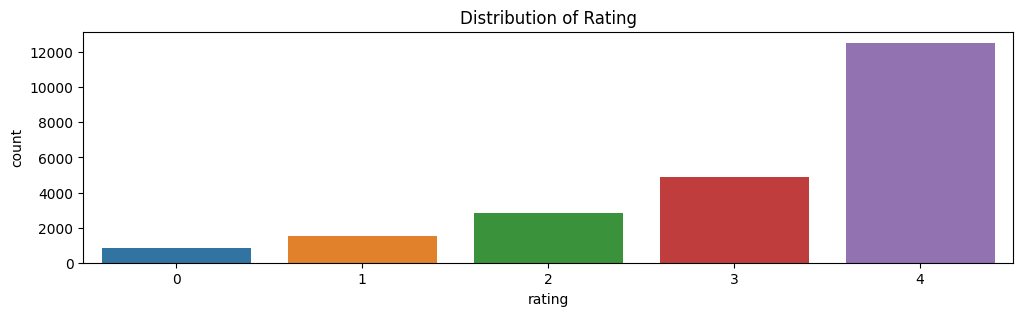

In [7]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

# Plot the distribution of each class
plt.figure(figsize=(12,3))
sns.countplot(x='rating', data=df_reviews)
plt.title('Distribution of Rating')
plt.show()

In [8]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['reviews'].values

In [9]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [10]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [11]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [12]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [13]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [14]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

### Tokenizar las palabras

In [15]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(tokens)

In [16]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [17]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)
print(sequences[:1])
print(text_sequences[:1])

[[253, 532, 917, 3, 662, 3, 68]]
['Absolutely wonderful - silky and sexy and comfortable']


Max length: 115


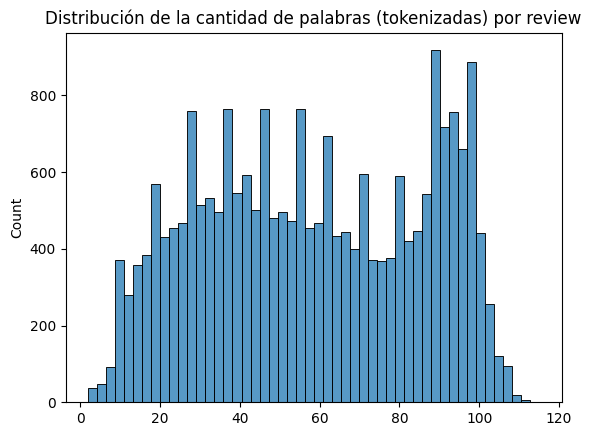

In [18]:
# Alumno: Determinar cual es la oración más larga
maxlen = max(len(s) for s in sequences)
print(f'Max length: {maxlen}')

# Podríamos optimizar el largo de la sentencia a analizar basandonos en la distribución
# de la cantidad de palabras por review. Sin embargo, por ahora vamos a tomar la máxima
len_vector = []
for i in sequences:
    len_vector.append(len(i))
sns.histplot(len_vector, bins=50)
plt.title('Distribución de la cantidad de palabras (tokenizadas) por review')
plt.show()

In [19]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import pad_sequences

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)
# Alumno: Observar las dimensiones de la variable input
X.shape


(22641, 115)

In [20]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = df_reviews['rating'].values

# convert y into one-hot format
n_classes = df_reviews['rating'].unique().shape[0]
print(f'Cantidad de clases: {n_classes}')
y = to_categorical(y, num_classes=n_classes)
print(y)
print(y.shape)

Cantidad de clases: 5
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]
(22641, 5)


### Separacion test-train

In [21]:
def plot_class_percentage(ohe_array, text):
    data= pd.DataFrame(ohe_array)
    data = data.apply(pd.value_counts)
    data = data.iloc[1, :]
    # print(data)
    plt.title('Class Distribution: ' + text)
    palette_color = sns.color_palette('bright')
    plt.pie(data, labels=data.index, colors=palette_color, autopct='%.0f%%')

X_train: (18112, 115)


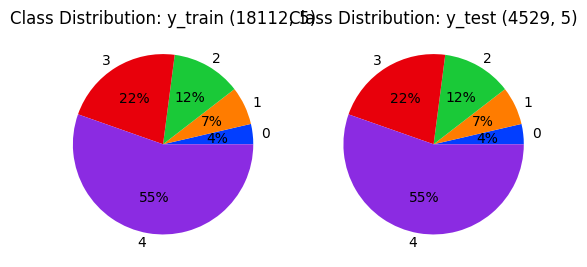

In [22]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"X_train: {X_train.shape}")
plt.subplot(1, 2, 1)
plot_class_percentage(y_train, f'y_train {y_train.shape}')
plt.subplot(1, 2, 2)
plot_class_percentage(y_test, f'y_test {y_test.shape}')
plt.show()
# Podemos ver que la proporción de clases se mantiene en train y test, pero es muy desbalanceada


#### Oversampling

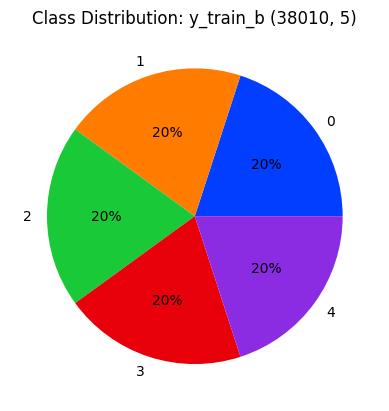

In [44]:
# Hacemos oversampling para tener una muestra balanceada (solo en set de train)
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Previo a eso, separamos el set de validacion para evitar tener datos repetidos
X_train_ib, X_val, y_train_ib, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# oversampler = SMOTE(random_state=0, sampling_strategy=0.1)
oversampler = RandomOverSampler(sampling_strategy='all')
X_train_b, y_train_b = oversampler.fit_resample(X_train_ib, y_train_ib)
# undersampler=RandomUnderSampler(sampling_strategy='majority')
# X_train, y_train = undersampler.fit_resample(X_train, y_train)

plot_class_percentage(y_train_b, f'y_train_b {y_train_b.shape}')


### 2 - Entrenar el modelo con Embeddings propios + LSTM

In [45]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train_b.shape[1] # max input sentence len
out_shape = n_classes # class classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 5


In [39]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = sentencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 115, 50)           100050    
                                                                 
 lstm_8 (LSTM)               (None, 115, 64)           29440     
                                                                 
 dropout_8 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_9 (LSTM)               (None, 128)               98816     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                

In [40]:
hist = model.fit(X_train_b, y_train_b, validation_data=(X_val, y_val), epochs=50)

Epoch 1/50
1188/1188 [==============================] - 46s 35ms/step - loss: 1.2963 - accuracy: 0.3790 - val_loss: 1.2313 - val_accuracy: 0.4006
Epoch 2/50
1188/1188 [==============================] - 21s 17ms/step - loss: 1.2340 - accuracy: 0.3996 - val_loss: 1.2091 - val_accuracy: 0.4073
Epoch 3/50
1188/1188 [==============================] - 17s 14ms/step - loss: 1.2154 - accuracy: 0.4081 - val_loss: 1.2144 - val_accuracy: 0.4069
Epoch 4/50
1188/1188 [==============================] - 18s 15ms/step - loss: 1.1981 - accuracy: 0.4137 - val_loss: 1.2130 - val_accuracy: 0.4103
Epoch 5/50
1188/1188 [==============================] - 17s 14ms/step - loss: 1.1841 - accuracy: 0.4183 - val_loss: 1.2188 - val_accuracy: 0.4031
Epoch 6/50
1188/1188 [==============================] - 17s 14ms/step - loss: 1.1728 - accuracy: 0.4260 - val_loss: 1.2189 - val_accuracy: 0.4093
Epoch 7/50
1188/1188 [==============================] - 18s 15ms/step - loss: 1.1613 - accuracy: 0.4307 - val_loss: 1.2344 -

In [46]:
from keras.regularizers import l2
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(units=128)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=64, activation='relu', activity_regularizer=l2(0.01)))
model2.add(Dropout(rate=0.3))
model2.add(Dense(units=out_shape, activation='sigmoid', activity_regularizer=l2(0.01)))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 115, 50)           100050    
                                                                 
 lstm_14 (LSTM)              (None, 115, 64)           29440     
                                                                 
 dropout_13 (Dropout)        (None, 115, 64)           0         
                                                                 
 lstm_15 (LSTM)              (None, 128)               98816     
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 5)                

In [47]:
hist2 = model2.fit(X_train_b, y_train_b, validation_data=(X_val, y_val), epochs=50)

Epoch 1/50
1188/1188 [==============================] - 45s 34ms/step - loss: 1.3142 - accuracy: 0.3825 - val_loss: 1.2522 - val_accuracy: 0.3985
Epoch 2/50
1188/1188 [==============================] - 20s 17ms/step - loss: 1.2406 - accuracy: 0.4063 - val_loss: 1.2351 - val_accuracy: 0.4052
Epoch 3/50
1188/1188 [==============================] - 18s 15ms/step - loss: 1.2167 - accuracy: 0.4112 - val_loss: 1.2341 - val_accuracy: 0.3994
Epoch 4/50
1188/1188 [==============================] - 19s 16ms/step - loss: 1.1929 - accuracy: 0.4249 - val_loss: 1.2252 - val_accuracy: 0.4111
Epoch 5/50
1188/1188 [==============================] - 18s 15ms/step - loss: 1.1744 - accuracy: 0.4346 - val_loss: 1.2349 - val_accuracy: 0.4100
Epoch 6/50
1188/1188 [==============================] - 17s 15ms/step - loss: 1.1602 - accuracy: 0.4408 - val_loss: 1.2490 - val_accuracy: 0.4115
Epoch 7/50
1188/1188 [==============================] - 17s 15ms/step - loss: 1.1401 - accuracy: 0.4563 - val_loss: 1.2490 -

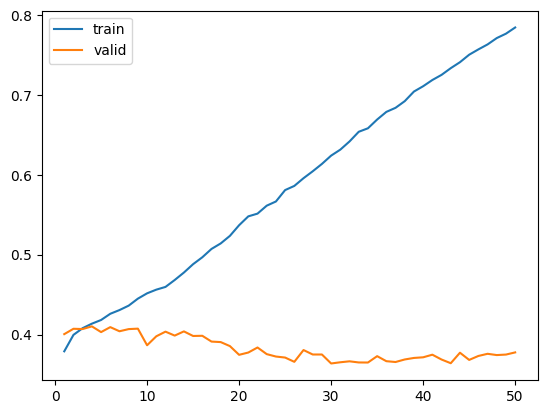

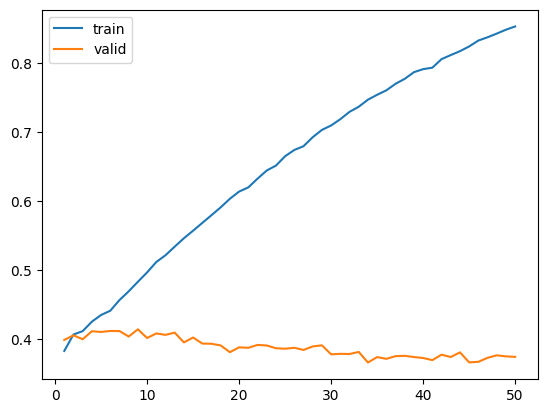

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [57]:
# Ambos modelos tienen overfitting, asique cortamos el entrenamiento antes
hist3 = model2.fit(X_train_b, y_train_b, validation_data=(X_val, y_val), epochs=14)

Epoch 1/14
1188/1188 [==============================] - 22s 19ms/step - loss: 0.3731 - accuracy: 0.8544 - val_loss: 3.2590 - val_accuracy: 0.3699
Epoch 2/14
1188/1188 [==============================] - 21s 18ms/step - loss: 0.3521 - accuracy: 0.8630 - val_loss: 3.3195 - val_accuracy: 0.3741
Epoch 3/14
1188/1188 [==============================] - 17s 15ms/step - loss: 0.3469 - accuracy: 0.8679 - val_loss: 3.2493 - val_accuracy: 0.3781
Epoch 4/14
1188/1188 [==============================] - 17s 14ms/step - loss: 0.3398 - accuracy: 0.8720 - val_loss: 3.4065 - val_accuracy: 0.3721
Epoch 5/14
1188/1188 [==============================] - 17s 15ms/step - loss: 0.3251 - accuracy: 0.8774 - val_loss: 3.4755 - val_accuracy: 0.3738
Epoch 6/14
1188/1188 [==============================] - 16s 14ms/step - loss: 0.3136 - accuracy: 0.8833 - val_loss: 3.5395 - val_accuracy: 0.3759
Epoch 7/14
1188/1188 [==============================] - 26s 22ms/step - loss: 0.3134 - accuracy: 0.8835 - val_loss: 3.3888 -

In [58]:
# model.evaluate(X_test, y_test)
from sklearn.metrics import f1_score
y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
f1sc = f1_score(y_test, y_pred, average='micro')
print(f'F1 score: {f1sc}')


142/142 [==============================] - 1s 5ms/step
F1 score: 0.5731949657761095
